<a href="https://colab.research.google.com/github/Berengarius13/Spam_Detection_LSTM/blob/main/Spam_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D #, Bidirectional
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data

In [4]:
df = pd.read_csv('Datasets/spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [6]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [7]:
df.head(6)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


In [8]:
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Create Binary Labels

In [10]:
X = df['data']
df['b_labels'] = df['labels'].map({'ham' : 0, 'spam' : 1})
y = df['b_labels'].values
print(df['data'])
print(y)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: data, Length: 5572, dtype: object
[0 0 1 ... 0 0 0]


In [11]:
# Get all the ham and spam emails
ham_messages = df[df.labels == 'ham']
spam_messages = df[df.labels == 'spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_messages.data.to_numpy().tolist())
spam_msg_text = " ".join(spam_messages.data.to_numpy().tolist())



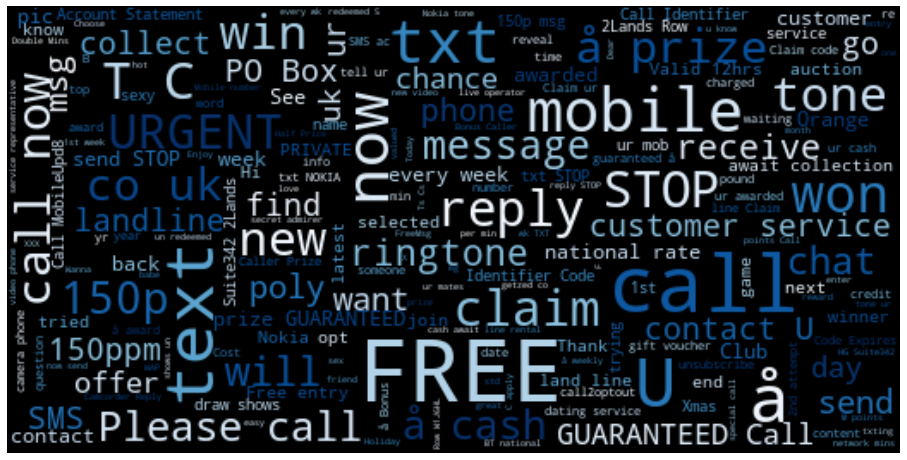

In [13]:
# wordcloud of spam messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

## Train Test Split

In [14]:
df_train, df_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33) 

## Preprocessing for Embedding

In [15]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

# Get sequences of integers for each sentence
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_test = tokenizer.texts_to_sequences(df_test)

In [16]:
# word integer mapping
word2idx = tokenizer.word_index # word integer pairs
V = len(word2idx)
print("Tokens found: ", V)

Tokens found:  7257


## Reshape Data for NN

In [17]:
# Need N x T matrix (can substitute D for T)
X_train = pad_sequences(sequences_train) # Pad sequences to make them of equal length
print("Train Sensor shape: ", X_train.shape)

T = X_train.shape[1]
print("Sequence length: ", T)

X_test = pad_sequences(sequences_test, maxlen=T)
print("Test Sensor shape: ", X_test.shape)

Train Sensor shape:  (3733, 189)
Sequence length:  189
Test Sensor shape:  (1839, 189)


# Build Model

In [47]:
N = df.shape[0] # Number of sequences
# T, the sequence length has been defined
D = 25 # Embedding dimensionality is a hyperparameter, because you get to choose any word vector sizez you want
M = 30 # Number of neurons per hidden layer

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i) # output dimensions are (V + 1, D) because embedding index starts at 1
x = LSTM(M, return_sequences=True)(x) # Bidirectional()
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.compile(optimizer=Adam(learning_rate =0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
r = model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              epochs = 20)

Epoch 1/20
117/117 [==============================] - 7s 45ms/step - loss: 0.4370 - accuracy: 0.8666 - val_loss: 0.3774 - val_accuracy: 0.8635
Epoch 2/20
117/117 [==============================] - 5s 42ms/step - loss: 0.3459 - accuracy: 0.8671 - val_loss: 0.3281 - val_accuracy: 0.8635
Epoch 3/20
117/117 [==============================] - 5s 42ms/step - loss: 0.2823 - accuracy: 0.8671 - val_loss: 0.2235 - val_accuracy: 0.8635
Epoch 4/20
117/117 [==============================] - 5s 42ms/step - loss: 0.1600 - accuracy: 0.9459 - val_loss: 0.1264 - val_accuracy: 0.9815
Epoch 5/20
117/117 [==============================] - 5s 42ms/step - loss: 0.0815 - accuracy: 0.9904 - val_loss: 0.0749 - val_accuracy: 0.9902
Epoch 6/20
117/117 [==============================] - 5s 43ms/step - loss: 0.0443 - accuracy: 0.9938 - val_loss: 0.0566 - val_accuracy: 0.9902
Epoch 7/20
117/117 [==============================] - 5s 43ms/step - loss: 0.0278 - accuracy: 0.9952 - val_loss: 0.0500 - val_accuracy: 0.9908

# Evaluate Model

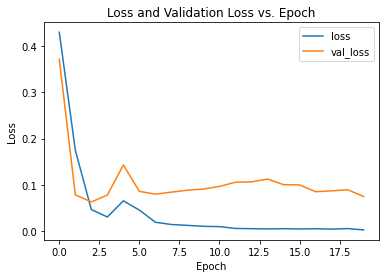

In [37]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

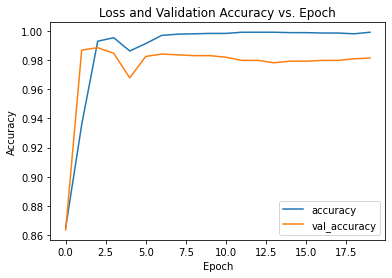

In [38]:
# Plot the loss
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Loss and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [39]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [40]:
# Prediction Function

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen= T)
    return model.predict(padded)

x = predict_spam(predict_msg)
x[2]

1/1 [==============================] - 0s 494ms/step


array([0.99978465], dtype=float32)